## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint, random,time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize



In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('wer

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12109


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'X', '.', 'VERB', 'ADJ', 'DET', 'NOUN', 'PRON', 'NUM', 'PRT', 'CONJ', 'ADP', 'ADV'}


 <b> 12 coarse tag classes as follows: </b>
 
PRT - particles or other function words <br>
NUM - cardinal numbers <br>
ADP - adpositions <br>
CONJ - conjunctions <br>
NOUN - nouns <br>
X - other: foreign words, typos, abbreviations <br>
ADJ - adjectives <br>
DET - determiners <br>
VERB - verbs     <br>
PRON - pronouns <br>
. - punctuation <br>
ADV - adverbs <br>

 

In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:

print("\n", "style")
print(word_given_tag('style','NOUN'))
print(word_given_tag('style','VERB'))
print(word_given_tag('style','ADJ'))

print("\n", "reported")
print(word_given_tag('reported','NOUN'))
print(word_given_tag('reported','VERB'))
print(word_given_tag('reported','ADJ'))


 style
(3, 27423)
(0, 12885)
(0, 6077)

 reported
(0, 27423)
(34, 12885)
(0, 6077)


In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('VERB', 'NOUN'))
print(t2_given_t1('PRT', 'NUM'))

(4234, 6077)
(4058, 27423)
(94, 3363)


In [14]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('PRT', '.'))


(2481, 11118)
(984, 11118)
(26, 11118)


In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
tags_matrix

array([[7.64818341e-02, 1.63798600e-01, 2.03632891e-01, 1.65710635e-02,
        5.51306568e-02, 6.13448061e-02, 5.60866781e-02, 2.70873168e-03,
        1.85787126e-01, 1.03569152e-02, 1.42925426e-01, 2.51752716e-02],
       [2.66234931e-02, 9.38118398e-02, 8.85051265e-02, 4.49721180e-02,
        1.73502430e-01, 2.23151639e-01, 6.53894618e-02, 8.05000886e-02,
        2.33855005e-03, 5.79240881e-02, 9.11135077e-02, 5.20777106e-02],
       [2.18005434e-01, 3.53123769e-02, 1.69188976e-01, 6.46488145e-02,
        1.33100510e-01, 1.10904150e-01, 3.62436958e-02, 2.28172299e-02,
        3.11214589e-02, 5.58789307e-03, 9.04928222e-02, 8.25766400e-02],
       [2.13921349e-02, 6.53282851e-02, 1.23416157e-02, 6.66447282e-02,
        5.10120112e-03, 6.96725368e-01, 6.58219506e-04, 2.04048045e-02,
        1.08606219e-02, 1.69491526e-02, 7.89863393e-02, 4.60753683e-03],
       [4.55094166e-02, 1.79864801e-02, 3.83872539e-02, 2.04973444e-01,
        5.31144394e-03, 6.40028954e-01, 3.74215352e-03, 2.19

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,.,VERB,ADJ,DET,NOUN,PRON,NUM,PRT,CONJ,ADP,ADV
X,0.076482,0.163799,0.203633,0.016571,0.055131,0.061345,0.056087,0.002709,0.185787,0.010357,0.142925,0.025175
.,0.026623,0.093812,0.088505,0.044972,0.173502,0.223152,0.065389,0.080500,0.002339,0.057924,0.091114,0.052078
VERB,0.218005,0.035312,0.169189,0.064649,0.133101,0.110904,0.036244,0.022817,0.031121,0.005588,0.090493,0.082577
ADJ,0.021392,0.065328,0.012342,0.066645,0.005101,0.696725,0.000658,0.020405,0.010861,0.016949,0.078986,0.004608
DET,0.045509,0.017986,0.038387,0.204973,0.005311,0.640029,0.003742,0.021970,0.000241,0.000483,0.009054,0.012313
NOUN,0.029136,0.239179,0.147978,0.012289,0.013310,0.264632,0.004923,0.009627,0.043832,0.041936,0.176275,0.016884
PRON,0.092819,0.041253,0.480901,0.074866,0.009549,0.211230,0.008021,0.007257,0.012223,0.004966,0.022918,0.033995
NUM,0.206661,0.118347,0.017544,0.034196,0.003271,0.355338,0.001487,0.184062,0.027951,0.013381,0.034790,0.002974
PRT,0.013403,0.041517,0.402746,0.086303,0.100360,0.242563,0.018960,0.058516,0.001635,0.002288,0.021576,0.010134
CONJ,0.007977,0.034256,0.153918,0.116847,0.121539,0.349132,0.058658,0.042234,0.004693,0.000469,0.054435,0.055842


In [18]:
tags_df.loc['.', :]

X       0.026623
.       0.093812
VERB    0.088505
ADJ     0.044972
DET     0.173502
NOUN    0.223152
PRON    0.065389
NUM     0.080500
PRT     0.002339
CONJ    0.057924
ADP     0.091114
ADV     0.052078
Name: ., dtype: float32

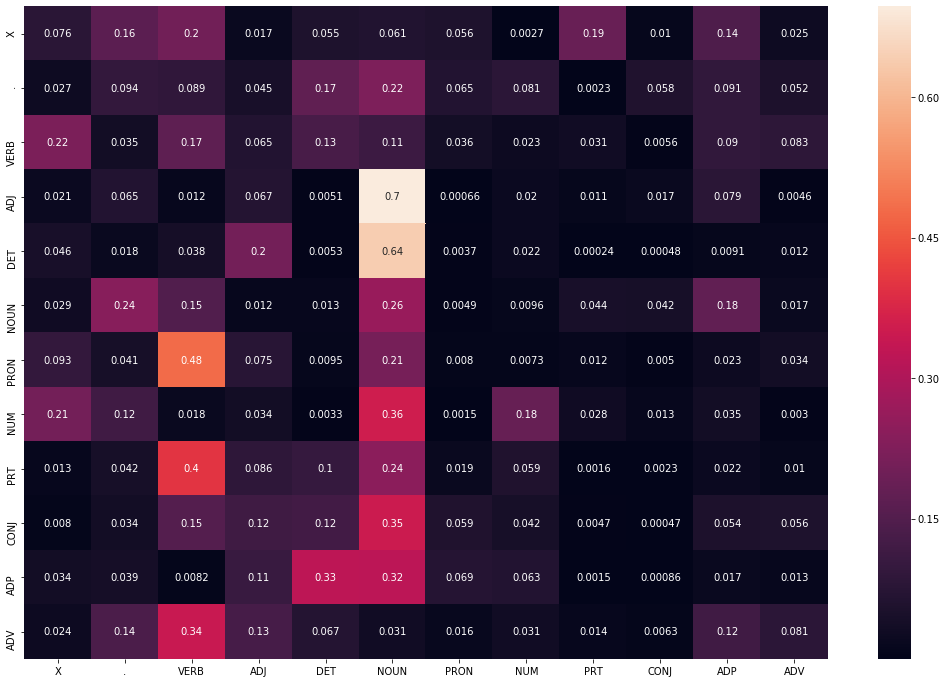

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
heat=sns.heatmap(tags_df,annot = True)
#below 2 lines are for temporary fix for matplotlib regression feature which broke heatmap  between 3.1.0 and 3.1.1
bottom, top = heat.get_ylim()
heat.set_ylim(bottom + 0.5, top - 0.5)
plt.show()


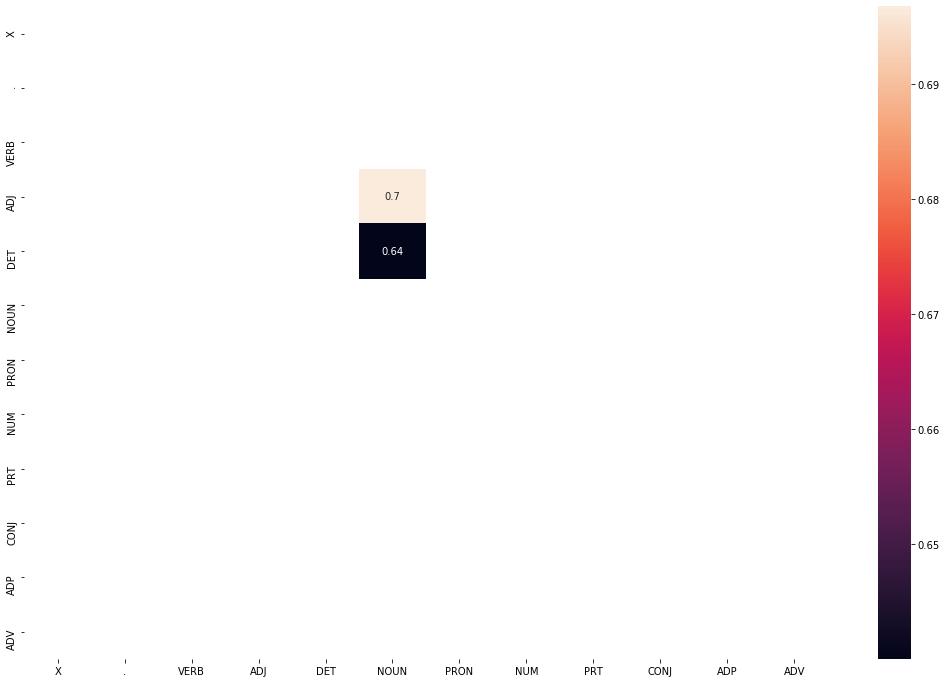

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
tag_freq_heat=sns.heatmap(tags_frequent,annot = True)
#below 2 lines are for temporary fix for matplotlib regression feature which broke heatmap  between 3.1.0 and 3.1.1
bottom, top = tag_freq_heat.get_ylim()
tag_freq_heat.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### We observe that transition probabilities are between Noun and other parts of speech such as Adjective and Determinant are highest

### Build the vanilla Viterbi based POS tagger

In [21]:
len(train_tagged_words)

95589

In [22]:
# Vanilla Viterbi
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Shearson', 'NOUN'),
  ('``', '.'),
  ('really', 'ADV'),
  ('only', 'ADV'),
  ('has', 'VERB'),
  ('$', '.'),
  ('300', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('capital', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Bowman', 'NOUN'),
  ('of', 'ADP'),
  ('S&P', 'NOUN'),
  ('.', '.')],
 [('ShareData', 'NOUN'),
  ('develops', 'VERB'),
  ('and', 'CONJ'),
  ('markets', 'VERB'),
  ('low-cost', 'ADJ'),
  ('software', 'NOUN'),
  (',', '.'),
  ('peripheral', 'ADJ'),
  ('equipment', 'NOUN'),
  ('and', 'CONJ'),
  ('accessories', 'NOUN'),
  ('for', 'ADP'),
  ('computers', 'NOUN'),
  ('.', '.')],
 [('Moscow', 'NOUN'),
  ('has', 'VERB'),
  ('settled', 'VERB'),
  ('pre-1917', 'ADJ'),
  ('debts', 'NOUN'),
  ('with', 'ADP'),
  ('other', 'ADJ'),
  ('countries', 'NOUN'),
  ('in', 'ADP'),
  ('recent', 'ADJ'),
  ('years', 'NOUN'),
  ('at', 'ADP'),
  ('less', 'ADJ'),
  ('than', 'ADP'),
  ('face', 'NOUN'),
  ('value', 'NOUN'),


In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [25]:
print("Time taken in seconds: ", difference)
print("\n")
print(tagged_seq)

Time taken in seconds:  23.029433488845825


[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'X'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'X'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'X'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 'NO

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print('Accuracy of Vanilla Viterbi Algo:',vanilla_viterbi_accuracy)

Accuracy of Vanilla Viterbi Algo: 0.9278350515463918


In [27]:
#checking incorrectly tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('ShareData', 'NOUN'), (('develops', 'X'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'X'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'X'), ('copied', 'VERB'))]]

The incorrect tagged cases are due to fact that when the algorithm hits an unknown word (i.e. not present in the training set hence emission probability is 0), it will assign the first tag to that word

### Solve the problem of unknown words

In [28]:
#Lets see how many unknown words we have (words that are present in test but not in train)

training_vocabulary_set = V
# building the test vocabulary to a set
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 4


Unknown Words : ['pre-1917', 'low-cost', 'develops', 'copied']


### Modified Viterbi 1

#### Use transition probability of tags when emission probability is zero (in case of unknown words)

In [29]:
def Modified_viterbi_trans_prob(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [30]:
# tagging the test sentences
start = time.time()
tagged_seq = Modified_viterbi_trans_prob(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified = len(check)/len(tagged_seq)
print('Modified_viterbi_trans_prob Accuracy: ',accuracy_viterbi_modified*100)

Time taken in seconds:  21.624194145202637
Modified_viterbi_trans_prob Accuracy:  93.81443298969072


We can see that our modified viterbi algoroth has increased accuracy of 93.81% as compared to 92.78% in Vanilla Viterbi Algorithm

### Lexicons and rule based tagger

In [31]:
# Lexicon (or unigram tagger)

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.911735797129939


#### Combining unigram tagger with a rule based regex tagger


In [32]:
# patterns for tagging using a rule based tagger
patterns = [
    (r'^([0-9]|[aA-zZ])+\-([0-9]|[aA-zZ])*$','ADJ'), # words such as '10-lap','30-day','York-based'
    (r'.*able$', 'ADJ'),                     # words ending with 'able' such as 'questionable'
    (r'.*ful$', 'ADJ'),                      # words ending with 'ful' such as 'useful'
    (r'.*ous$', 'ADJ'),                      # words ending with 'ous' such as 'Previous'
    
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alpha Numeric such as Door Number, Street Number etc
    (r'.*ers$', 'NOUN'),                     # words ending with 'ers' such as 'filters','workers'
    (r'.*ment$', 'NOUN'),                    # words ending with 'ment' such as 'reinvestment' 
    (r'.*town$', 'NOUN'),                    # words ending with 'town' such as 'town','downtown'  
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),    # words such as 'Nov.','Mr.','Inc.'
    
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'
    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'^(0|([*|-|$].*))','X'),               # words such as '*', '0', *-1', '*T*-1', '*ICH*-1', '*?*'   
    
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # determinants     
    (r'.*', 'NOUN')  
    ]
    

In [33]:
# Rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
accuracy_rule_based_unigram_tagger=rule_based_unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger with rule based backoff is: ",+accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger with rule based backoff is:  0.9598977786514645


In [34]:
# Bigram tagger backed up by the rule-based-unigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
accuracy_bigram_tagger=bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger with rule based unigram backoff is: ",+accuracy_bigram_tagger)

The accuracy of the Bigram Tagger with rule based unigram backoff is:  0.9640259484961667


In [35]:
#trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
accuracy_trigram_tagger=trigram_tagger.evaluate(test_set)
print("The accuracy of the trigram Tagger with Bigram tagger as backoff is: ",+accuracy_trigram_tagger)

The accuracy of the trigram Tagger with Bigram tagger as backoff is:  0.9630430509140947


#### Lets modify Viterbi Algo to include Trigram tagger as backoff

In [36]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    # specify patterns for tagging. I have identified most of the patterns from the first 100 sentences in universal dataset
    patterns = [
    (r'^([0-9]|[aA-zZ])+\-([0-9]|[aA-zZ])*$','ADJ'), # words such as '10-lap','30-day','York-based'
    (r'.*able$', 'ADJ'),                     # words ending with 'able' such as 'questionable'
    (r'.*ful$', 'ADJ'),                      # words ending with 'ful' such as 'useful'
    (r'.*ous$', 'ADJ'),                      # words ending with 'ous' such as 'Previous'
    
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alpha Numeric such as Door Number, Street Number etc
    (r'.*ers$', 'NOUN'),                     # words ending with 'ers' such as 'filters','workers'
    (r'.*ment$', 'NOUN'),                    # words ending with 'ment' such as 'reinvestment' 
    (r'.*town$', 'NOUN'),                    # words ending with 'town' such as 'town','downtown'  
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),    # words such as 'Nov.','Mr.','Inc.'
    
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'
    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'^(0|([*|-|$].*))','X'),               # words such as '*', '0', *-1', '*T*-1', '*ICH*-1', '*?*'   
    
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # determinants     
    (r'.*', 'NOUN')  
    ]
    
    rule_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])    

In [37]:
# Modified Viterbi Algo- Technique II - Backoff trigram rule based tagger
def Viterbi_tri_backoff(words, train_bag = train_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    # use the trigram tagger backed up by the rule based tagger for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [38]:
# tagging the test sentences.
start = time.time()
viterbi_trigram_tagged_seq = Viterbi_tri_backoff(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_rule_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)
print("The accuracy of Viterbi Algo with rule based Trigram tagger as backoff is:: ",+viterbi_trigram_rule_accuracy)

Time taken in seconds:  38.30050992965698
The accuracy of Viterbi Algo with rule based Trigram tagger as backoff is::  0.9587628865979382


In [39]:
viterbi_trigram_incorrect_tagged_cases = [j for i, j in enumerate(zip(viterbi_trigram_tagged_seq, test_run_base)) if j[0]!=j[1]]
viterbi_trigram_incorrect_tagged_cases

[(('develops', 'NOUN'), ('develops', 'VERB')),
 (('markets', 'NOUN'), ('markets', 'VERB')),
 (('test', 'VERB'), ('test', 'NOUN')),
 (('out', 'PRT'), ('out', 'ADV'))]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [40]:
evalute_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy * 100], 
                  ['Vanilla Viterbi Modified', accuracy_viterbi_modified * 100], 
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_rule_accuracy * 100]]

evalute_data_acccuracy_df = pd.DataFrame(evalute_data, columns = ['Algorithm', 'Accuracy'])
evalute_data_acccuracy_df.reset_index()
evalute_data_acccuracy_df

,Algorithm,Accuracy
0,Vanilla Viterbi,92.783505
1,Vanilla Viterbi Modified,93.814433
2,Unigram Tagger,91.173580
3,Unigram + RegexpTagger,95.989778
4,Bigram Tagger + Unigram_tagger,96.402595
5,Trigram Tagger + Bigram_tagger,96.304305
6,Viterbi + Trigram_tagger,95.876289


[Text(0, 0, 'Vanilla Viterbi'),
 Text(0, 0, 'Vanilla Viterbi Modified'),
 Text(0, 0, 'Unigram Tagger'),
 Text(0, 0, 'Unigram + RegexpTagger'),
 Text(0, 0, 'Bigram Tagger + Unigram_tagger'),
 Text(0, 0, 'Trigram Tagger + Bigram_tagger'),
 Text(0, 0, 'Viterbi + Trigram_tagger')]

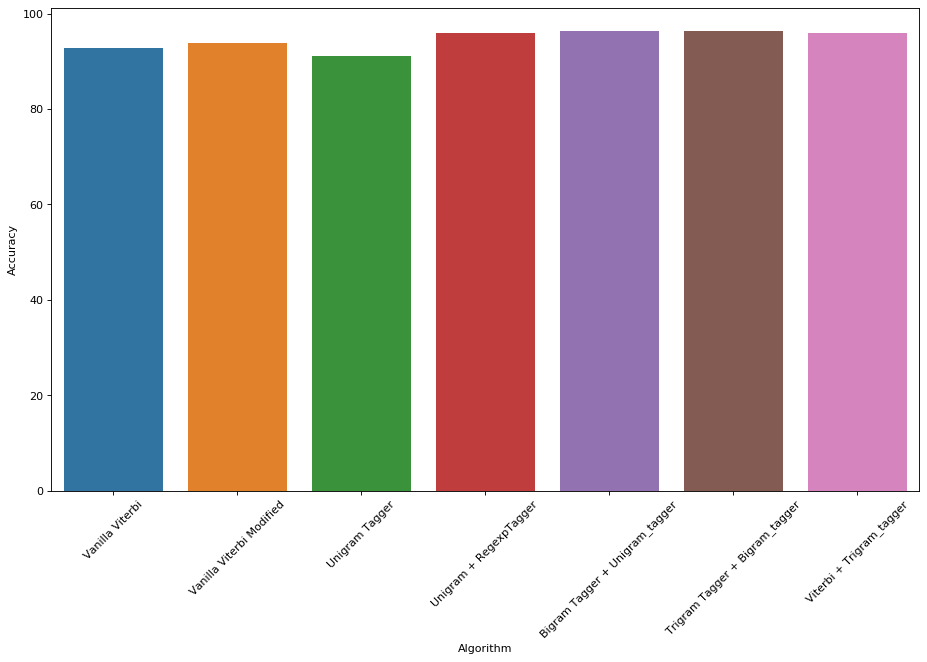

In [41]:
fig, ax1 = plt.subplots(figsize=(14,8),dpi=80)
bar = sns.barplot(x='Algorithm', y='Accuracy', data = evalute_data_acccuracy_df)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [42]:
#function to compare taggers
def compareAlgos(sentence):
    words = word_tokenize(sentence)
    tagged_seq = Viterbi(words)
    print("\033[1m" + 'Vanilla Viterbi Tagged Sentence:' + "\033[0m")
    print(tagged_seq)
    print('\n')

    tagged_seq_modified1 = Modified_viterbi_trans_prob(words)
    print("\033[1m" + 'Modified Veterbi techniques 1 Sentence:' + "\033[0m")
    print(tagged_seq_modified1)
    print('\n')
    tagged_seq_modified2 = Viterbi_tri_backoff(words)
    print("\033[1m" + 'Modified Veterbi techniques 2 (trigram backoff tagged) Sentence:' + "\033[0m")
    print(tagged_seq_modified2)

    

In [43]:
compareAlgos("Android is a mobile operating system developed by Google.")

Vanilla Viterbi Tagged Sentence:
[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]


Modified Veterbi techniques 1 Sentence:
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]


Modified Veterbi techniques 2 (trigram backoff tagged) Sentence:
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


<b>Android was tagged as X initally which got correctly recognized as NOUN later</b>

In [44]:
compareAlgos("Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.")

Vanilla Viterbi Tagged Sentence:
[('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')]


Modified Veterbi techniques 1 Sentence:
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


Modified Veterbi techniques 2 (trigram backoff tagged) Sentence:
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehos

<b>Words like Google,Twitter,firehose which were tagged as X initially are getting correctly identified as Noun in the trigram approach</b>

In [45]:
compareAlgos("The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.")

Vanilla Viterbi Tagged Sentence:
[('The', 'DET'), ('2018', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'X'), ('FIFA', 'X'), ('World', 'NOUN'), ('Cup', 'X'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'X'), ('contested', 'X'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


Modified Veterbi techniques 1 Sentence:
[('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


Modified Veterbi techniques 2 (trigram backoff tagged) Sentence:
[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN')

<b>FIFA, CUP got corrected to NOUN. <br>
'contested' was tagged as X initially and was tagged and VERB correctly later. </b>

In [46]:
compareAlgos("NASA invited social media users to experience the launch of ICESAT-2 Satellite.")

Vanilla Viterbi Tagged Sentence:
[('NASA', 'X'), ('invited', 'X'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'X'), ('Satellite', 'X'), ('.', '.')]


Modified Veterbi techniques 1 Sentence:
[('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'NOUN'), ('.', '.')]


Modified Veterbi techniques 2 (trigram backoff tagged) Sentence:
[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADJ'), ('Satellite', 'NOUN'), ('.', '.')]


<b>'invited' got corrected to VERB, 'NASA' and 'Satellite' got corrected to NOUN</b>